In this notebook, we will explore Gaussian Process Machine Learning model for the ethanol dataset. The hold-out set containing three electrophiles of 1H-indol-5-yl N,N-dimethylsulfamate, Ethyl 4-chloro-3-fluorobenzoate, and Clofibrate will be used as the external electrophile testing set.

# Machine Learning for Nickel Catalyzed Borylation in EtOH

In [1]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math as math
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

### Load Preprocessed Ethanol Dataset

In [2]:
dataset = pd.read_csv("./data/data_EtOH_Final.csv")
dataset.head()

,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Ligand,Ligand_inchi,Product_inchi,Solvent_inchi,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,50.731606,50.731606,351.19888,1.840787,-0.055960,A-paPhos,InChI=1S/C20H20NP/c1-21(2)17-13-15-20(16-14-17...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,80.673770,61.935337,479.46484,1.803143,-0.058457,CX-FBu,InChI=1S/C29H39P.BF4/c1-2-3-22-29(27-20-12-10-...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,107.755370,56.694310,386.44120,1.805810,-0.058387,CX-PCy,InChI=1S/C22H30NP/c1-4-11-19(12-5-1)23-18-10-1...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,117.597336,54.091050,618.03375,1.817123,-0.054418,Cy-BippyPhos,InChI=1S/C36H39N4P/c1-6-16-28(17-7-1)34-36(35(...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,111.484024,57.033180,402.37967,1.816461,-0.061351,Cy-JohnPhos,InChI=1S/C24H31P/c1-4-12-20(13-5-1)23-18-10-11...,InChI=1S/C8H8BNO2/c11-9(12)7-1-2-8-6(5-7)3-4-1...,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",80.44


### Prepare Hold-out Electrophiles Testing Set¶

In [3]:
dataset.Electrophile.unique().tolist()

['1H-indol-5-yl\xa0N,N-dimethylsulfamate',
 "2-bromo-1,1'-biphenyl",
 '2-Chloro-5-fluorotoluene',
 '2-Chloro-m-xylene',
 '(2-Methyl-1,3-benzothiazol-5-yl)\xa0N,N-dimethylsulfamate',
 '3-Bromothiophene',
 '3-Chloro-2-methylaniline',
 '4-Bromoanisole',
 '4-Bromobenzotrifluoride',
 '4-Chloro-N,N-dimethylbenzamide',
 '5-chloroindole',
 'BMS-929356',
 'Ethyl\xa04-chloro-3-fluorobenzoate',
 'methyl\xa04-bromobenzoate',
 'quinolin-6-yl dimethylsulfamate',
 '3-Bromoquinoline',
 '3-bromo-2-methylpyridine',
 'Clofibrate',
 '4-Bromo-2-fluoroanisole',
 '4-Bromo-2-fluorobenzonitrile',
 '(4-Phenylphenyl) N,N-dimethylsulfamate',
 '4-Bromo-1,2-(methylenedioxy)benzene',
 '5-Bromobenzofuran',
 '4-chloro-1-fluoro-2-methoxybenzene',
 '4-chlorobenzotrifluoride',
 '3-chloroquinoline',
 '5-bromo-2,4-dimethoxypyrimidine',
 'methyl\xa04-chlorobenzoate',
 '5-Chloro-1,3-benzodioxole',
 '4-chloro-2-fluoro-1-methoxybenzene',
 '4-Chloro-2-fluoroanisole',
 '4-Chlorobiphenyl',
 '4-Bromobiphenyl',
 '4-Chloro-2-fluorob

In [4]:
#Retrieve the three electrophiles and store the features in a separate dataframe 
indices=[0,12,17]
mapped = map(dataset.Electrophile.unique().tolist().__getitem__, indices)
external_list=list(mapped)
ML_data_validation = dataset[dataset['Electrophile'].isin(external_list)]
ML_data_validation2 = ML_data_validation.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_validation2.shape)
ML_data_validation2.head()

(69, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
0,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,87.13
1,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,6.37
2,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,71.75
3,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,64.52
4,1.11,140.296,0.33,8.371,0.338,105.274,102.178,-0.291,-0.456,12.9615,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,80.44


In [5]:
#Keep the rest of the dataset for model training purpose
exclude_list = ML_data_validation.index.values.tolist()
ML_data_traintest = dataset[~dataset.index.isin(exclude_list)]
ML_data_traintest2 = ML_data_traintest.drop(['Electrophile_inchi', 'Solvent_inchi', 'Ligand_inchi', 'Product_inchi', 'Electrophile', 'Ligand'], axis = 1)
print (ML_data_traintest2.shape)
ML_data_traintest2.head()

(710, 157)


,ArylHalide_CX_Lowdin,ArylHalide_C_Chem Shift,ArylHalide_C_Electrostatic,ArylHalide_C_Exposed Area,ArylHalide_C_Mulliken,ArylHalide_XY_Chem Shift_Max,ArylHalide_XY_Chem Shift_Min,ArylHalide_XY_Electrostatic_Max,ArylHalide_XY_Electrostatic_Min,ArylHalide_XY_Exposed Area_Avg,...,Kraken_vbur_qvtot_min_min,Kraken_vbur_qvtot_min_vburminconf,Kraken_vbur_ratio_vbur_vtot_boltz,Kraken_vbur_vbur_boltz,Kraken_vbur_vbur_max,Kraken_vbur_vbur_min,Kraken_vbur_vtot_boltz,Kraken_vmin_r_boltz,Kraken_vmin_vmin_boltz,Yield
23,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,59.829678,59.829678,0.144453,50.731606,50.731606,50.731606,351.19888,1.840787,-0.055960,79.290
24,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,47.895260,67.167030,0.134809,64.636100,80.673770,61.935337,479.46484,1.803143,-0.058457,15.445
25,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,36.894516,75.417816,0.211005,81.541550,107.755370,56.694310,386.44120,1.805810,-0.058387,54.590
26,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,45.164505,77.044235,0.160584,99.246600,117.597336,54.091050,618.03375,1.817123,-0.054418,51.530
27,1.09,136.282,-0.197,7.369,-0.025,139.527,126.017,0.327,0.007,8.957,...,44.561430,72.197180,0.212085,85.339290,111.484024,57.033180,402.37967,1.816461,-0.061351,45.430


In [6]:
Y_train = ML_data_traintest2['Yield']
X_train = ML_data_traintest2.drop(columns=['Yield'])

We will use Pipeline process from Scikit Learn where we can assemble several steps that can be cross-validated together while applying normalization and grid search to find optimal settings for different parameters.

### Lasso

In [7]:
%%time
steps = [('scaler', StandardScaler()), ('model', Lasso())]
pipeline = Pipeline(steps)
parameters = {'model__alpha': np.logspace(-10, 1, 50)}

lasso_search = GridSearchCV(pipeline, 
                         parameters, 
                         cv = 5, 
                         scoring="neg_mean_squared_error", 
                         verbose=3)

lasso_search.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .............................model__alpha=1e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.5971936624, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.193128829844, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............................model__alpha=1e-10; total time=   0.1s
[CV 3/5] END .............................model__alpha=1e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.97237751432, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.56434457959, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............................model__alpha=1e-10; total time=   0.1s
[CV 5/5] END .............................model__alpha=1e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.5060355064, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.59703641252, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.2s
[CV 2/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.19294746727, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.97217984522, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.2s
[CV 4/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.56415025108, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.50577382048, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=1.67683293681101e-10; total time=   0.2s
[CV 1/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.59677273025, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.19264335138, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=2.811768697974225e-10; total time=   0.2s
[CV 3/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.97184838638, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.56382439453, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=2.811768697974225e-10; total time=   0.1s
[CV 5/5] END .............model__alpha=2.811768697974225e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.50533501651, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.59633057973, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s
[CV 2/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.19213340165, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.97129258595, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s
[CV 4/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.56327798768, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.50459921619, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=4.71486636345739e-10; total time=   0.2s
[CV 1/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.595589167235, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.19127829964, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s
[CV 3/5] END .............model__alpha=7.906043210907701e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.97036060081, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.562361755, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=7.906043210907701e-10; total time=   0.1s
[CV 5/5] END .............model__alpha=7.906043210907701e-10; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.50336540156, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.59434594186, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.1s
[CV 2/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.18984443679, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.96879781835, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.1s
[CV 4/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.56082538524, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.50129650033, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.3257113655901108e-09; total time=   0.2s
[CV 1/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.59226126023, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.18744008824, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s
[CV 3/5] END .............model__alpha=2.222996482526191e-09; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.96617729249, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.55824914978, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s
[CV 5/5] END .............model__alpha=2.222996482526191e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.49782729965, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.58876559758, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s
[CV 2/5] END .............model__alpha=3.727593720314938e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.18340839775, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.96178310798, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=3.727593720314938e-09; total time=   0.1s
[CV 4/5] END .............model__alpha=3.727593720314938e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.55392923321, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.49201002982, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=3.727593720314938e-09; total time=   0.2s
[CV 1/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.582903954644, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.17664792561, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s
[CV 3/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.95441479322, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.54668545432, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=6.250551925273976e-09; total time=   0.2s
[CV 5/5] END .............model__alpha=6.250551925273976e-09; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.48225544086, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.57307495625, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.2s
[CV 2/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.16531174319, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.94205935625, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s
[CV 4/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.5345388454, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.46589862928, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.0481131341546852e-08; total time=   0.1s
[CV 1/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.556593362606, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.14630285824, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s
[CV 3/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.92134134007, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.51417100544, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.2s
[CV 5/5] END ............model__alpha=1.7575106248547893e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.43847099821, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.528956465685, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.2s
[CV 2/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.114428132, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.88660065437, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s
[CV 4/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.48001752389, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.39247947192, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=2.9470517025518096e-08; total time=   0.1s
[CV 1/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.48261395911, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63665.06097953339, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.2s
[CV 3/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.82834623358, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.42274779725, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.2s
[CV 5/5] END ............model__alpha=4.9417133613238385e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.31535944543, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.40490518388, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=8.286427728546843e-08; total time=   0.2s
[CV 2/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63664.97135514349, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.73066303405, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s
[CV 4/5] END .............model__alpha=8.286427728546843e-08; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.3267159046, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66877.18604226988, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=8.286427728546843e-08; total time=   0.1s
[CV 1/5] END .............model__alpha=1.389495494373136e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.2746001724, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63664.821069958176, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s
[CV 3/5] END .............model__alpha=1.389495494373136e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.56686387522, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71413.16568610711, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s
[CV 5/5] END .............model__alpha=1.389495494373136e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66876.96919960117, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58832.05609937537, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=2.329951810515372e-07; total time=   0.2s
[CV 2/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63664.56906665451, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74240.29219793528, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=2.329951810515372e-07; total time=   0.2s
[CV 4/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71412.8956650314, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66876.60559244771, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=2.329951810515372e-07; total time=   0.1s
[CV 1/5] END .............model__alpha=3.906939937054621e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58831.68970705694, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63664.146498775735, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s
[CV 3/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74239.83162309264, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71412.4428819687, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=3.906939937054621e-07; total time=   0.2s
[CV 5/5] END .............model__alpha=3.906939937054621e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66875.99588898779, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58831.07531995892, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.2s
[CV 2/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63663.43792180834, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74239.05929930089, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s
[CV 4/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71411.683632458, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66874.97353217634, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=6.55128556859551e-07; total time=   0.1s
[CV 1/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58830.04507183526, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63662.24975315444, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.2s
[CV 3/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74237.76419430114, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71410.41047549968, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.1s
[CV 5/5] END ............model__alpha=1.0985411419875572e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66873.25925005751, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58828.31745149538, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s
[CV 2/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63660.25738058166, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74235.59238734575, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.2s
[CV 4/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71408.27554106466, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66870.38479626553, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.8420699693267164e-06; total time=   0.1s
[CV 1/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58825.42033697886, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63656.91646998782, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.1s
[CV 3/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74231.950258088, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71404.69541802583, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.2s
[CV 5/5] END ............model__alpha=3.0888435964774785e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66865.56514259355, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58820.56185789953, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=5.179474679231212e-06; total time=   0.2s
[CV 2/5] END .............model__alpha=5.179474679231212e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63651.31424553856, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74225.84197025972, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=5.179474679231212e-06; total time=   0.1s
[CV 4/5] END .............model__alpha=5.179474679231212e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71398.69166998596, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66857.48425770314, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=5.179474679231212e-06; total time=   0.2s
[CV 1/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58812.41355108776, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63641.92005768757, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.2s
[CV 3/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74215.59646694428, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71388.6229883084, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.1s
[CV 5/5] END ..............model__alpha=8.68511373751352e-06; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66843.93642723539, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58798.74630176863, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.2s
[CV 2/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63626.16714763454, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74198.40824706126, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.2s
[CV 4/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71371.7356265403, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66821.22597889056, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=1.4563484775012445e-05; total time=   0.1s
[CV 1/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58775.817394662095, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63599.75050240686, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s
[CV 3/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74169.5634594537, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71343.40730044615, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s
[CV 5/5] END ............model__alpha=2.4420530945486497e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66783.16399269082, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58737.3381667863, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=4.094915062380427e-05; total time=   0.1s
[CV 2/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63555.45032857738, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74121.13309452214, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s
[CV 4/5] END .............model__alpha=4.094915062380427e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71295.87386378947, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66719.39613287915, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=4.094915062380427e-05; total time=   0.2s
[CV 1/5] END .............model__alpha=6.866488450042999e-05; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58672.72804521899, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63481.157040243466, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s
[CV 3/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74039.74637919289, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71216.08437201094, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=6.866488450042999e-05; total time=   0.1s
[CV 5/5] END .............model__alpha=6.866488450042999e-05; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66612.62814665788, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58564.15271816698, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=0.00011513953993264481; total time=   0.1s
[CV 2/5] END ............model__alpha=0.00011513953993264481; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63356.571311101594, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73902.79520402646, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=0.00011513953993264481; total time=   0.2s
[CV 4/5] END ............model__alpha=0.00011513953993264481; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71082.06592225048, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66434.07826662417, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=0.00011513953993264481; total time=   0.2s
[CV 1/5] END ............model__alpha=0.00019306977288832496; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58381.49778602018, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63147.688440335485, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s
[CV 3/5] END ............model__alpha=0.00019306977288832496; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73671.87299643806, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70856.70273194437, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ............model__alpha=0.00019306977288832496; total time=   0.2s
[CV 5/5] END ............model__alpha=0.00019306977288832496; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66136.05424921955, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58073.78633470782, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ............model__alpha=0.00032374575428176466; total time=   0.2s
[CV 2/5] END ............model__alpha=0.00032374575428176466; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62797.76867910803, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73281.17048974479, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ............model__alpha=0.00032374575428176466; total time=   0.1s
[CV 4/5] END ............model__alpha=0.00032374575428176466; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70477.27882560808, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65640.34003729593, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ............model__alpha=0.00032374575428176466; total time=   0.2s
[CV 1/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57554.82508927036, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62212.36728781542, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=0.0005428675439323859; total time=   0.2s
[CV 3/5] END .............model__alpha=0.0005428675439323859; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72616.82362561114, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69837.63831467765, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=0.0005428675439323859; total time=   0.1s
[CV 5/5] END .............model__alpha=0.0005428675439323859; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64821.12486040363, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56678.39818315272, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=0.0009102981779915227; total time=   0.2s
[CV 2/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61236.50422780602, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71478.77957800131, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=0.0009102981779915227; total time=   0.2s
[CV 4/5] END .............model__alpha=0.0009102981779915227; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68758.04157608406, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63481.493965570546, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=0.0009102981779915227; total time=   0.2s
[CV 1/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55242.772995155625, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59622.76908331023, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END .............model__alpha=0.0015264179671752333; total time=   0.2s
[CV 3/5] END .............model__alpha=0.0015264179671752333; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69590.83424581337, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66933.55336895399, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END .............model__alpha=0.0015264179671752333; total time=   0.2s
[CV 5/5] END .............model__alpha=0.0015264179671752333; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61328.73977323102, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52762.434948001646, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s
[CV 2/5] END .............model__alpha=0.0025595479226995332; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56979.6461592206, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66349.07357926769, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s
[CV 4/5] END .............model__alpha=0.0025595479226995332; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63792.0899865142, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57966.212920738224, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END .............model__alpha=0.0025595479226995332; total time=   0.1s
[CV 1/5] END ..............model__alpha=0.004291934260128779; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48610.15034127334, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52718.9637593293, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s
[CV 3/5] END ..............model__alpha=0.004291934260128779; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60366.9105824479, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58675.60902586844, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=0.004291934260128779; total time=   0.1s
[CV 5/5] END ..............model__alpha=0.004291934260128779; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52904.819444374014, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41683.12326240909, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s
[CV 2/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46199.276903643084, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49013.23998397293, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=0.007196856730011514; total time=   0.2s
[CV 4/5] END ..............model__alpha=0.007196856730011514; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48496.14695816174, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45672.873062766856, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=0.007196856730011514; total time=   0.2s
[CV 1/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32750.524994648338, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35500.61691858407, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 3/5] END ..............model__alpha=0.012067926406393264; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32892.85563890704, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31474.778719057045, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ..............model__alpha=0.012067926406393264; total time=   0.1s
[CV 5/5] END ..............model__alpha=0.012067926406393264; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30692.74206433139, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12769.209665801958, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s
[CV 2/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22053.092274895826, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10089.953197155366, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ..............model__alpha=0.020235896477251554; total time=   0.2s
[CV 4/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10634.397627868879, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16059.958077642194, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ..............model__alpha=0.020235896477251554; total time=   0.1s
[CV 1/5] END ................model__alpha=0.0339322177189533; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1572.451694280724, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9137.121841471846, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ................model__alpha=0.0339322177189533; total time=   0.2s
[CV 3/5] END ................model__alpha=0.0339322177189533; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2909.485599385982, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1270.6229042710038, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ................model__alpha=0.0339322177189533; total time=   0.1s
[CV 5/5] END ................model__alpha=0.0339322177189533; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2632.48371277799, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1328.2396402807644, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 2/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2213.9903505089896, tolerance: 40.11242915907062
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.3274502399145, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.05689866029018305; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.50100379317882, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 816.730363075505, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END ...............model__alpha=0.05689866029018305; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.09235822988558, tolerance: 36.00594430408222
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 3/5] END ...............model__alpha=0.09540954763499924; total time=   0.2s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.87414377278765, tolerance: 42.859971103167595
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.4643434596946, tolerance: 40.1785919770162
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.09540954763499924; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.88094659519265, tolerance: 37.0766181102993
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 3/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.15998587196060574; total time=   0.1s
[CV 1/5] END ...............model__alpha=0.26826957952797276; total time=   0.1s
[CV 2/5] END ...............model__alpha=0.26826957952797276; total time=   0.0s
[CV 3/5] END ...............model__alpha=0.26826957952797276; total time=   0.1s
[CV 4/5] END ...............model__alpha=0.26826957952797276; total time=   0.1s
[CV 5/5] END ...............model__alpha=0.26826957952797276; total time=   0.0s
[CV 1/5] END ................model__alpha=0.4498432668969453; total time=   0.1s
[CV 2/5] END ................model__alpha=0.4498432668969453; total time=   0.1s
[CV 3/5] END ................model__alpha=0.4498432668969453; total time=   0.0s
[CV 4/5] END ...............

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([1.00000000e-10, 1.67683294e-10, 2.81176870e-10, 4.71486636e-10,
       7.90604321e-10, 1.32571137e-09, 2.22299648e-09, 3.72759372e-09,
       6.25055193e-09, 1.04811313e-08, 1.75751062e-08, 2.94705170e-08,
       4.94171336e-08, 8.28642773e-08, 1.38949549e-07...
       1.93069773e-04, 3.23745754e-04, 5.42867544e-04, 9.10298178e-04,
       1.52641797e-03, 2.55954792e-03, 4.29193426e-03, 7.19685673e-03,
       1.20679264e-02, 2.02358965e-02, 3.39322177e-02, 5.68986603e-02,
       9.54095476e-02, 1.59985872e-01, 2.68269580e-01, 4.49843267e-01,
       7.54312006e-01, 1.26485522e+00, 2.12095089e+00, 3.55648031e+00,
       5.96362332e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error', verbose=3)

In [8]:
lasso_search.best_params_

{'model__alpha': 0.26826957952797276}

In [9]:
lasso_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.26826957952797276))])

### Hold-out Electrophiles Testing set Evaluation

In [10]:
ext_y=ML_data_validation2['Yield']
ext_X=ML_data_validation2.iloc[:, ML_data_validation2.columns.isin(X_train.columns)]
Y_Pred = lasso_search.best_estimator_.predict(ext_X)

In [11]:
mse = mean_squared_error(ext_y, Y_Pred)
print(math.sqrt(mse))

18.843818155421783


### Plot Parity Plot

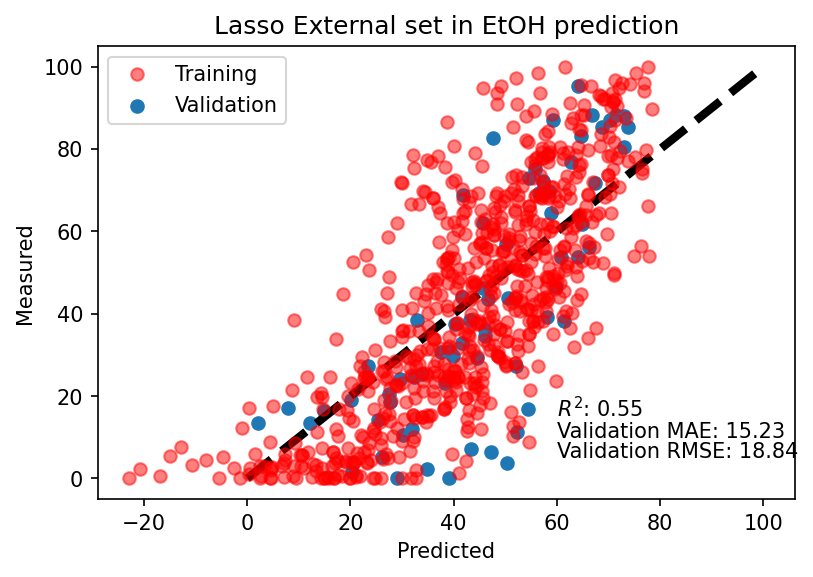

In [12]:
plt.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots()
ax.scatter(Y_Pred,ext_y,label="Validation")
ax.plot( [0,100],[0,100], 'k--', lw=4)
ax.plot(lasso_search.best_estimator_.predict(X_train), Y_train, "or", alpha=0.5, label="Training")
ax.text(60,15,r'$R^2$: {:0.2f}'.format(r2_score(ext_y,Y_Pred)))
ax.text(60,10,'Validation MAE: {:0.2f}'.format(mean_absolute_error(Y_Pred,ext_y)))
ax.text(60,5,'Validation RMSE: {:0.2f}'.format(np.sqrt(mean_squared_error(Y_Pred,ext_y))))
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
ax.set_title('Lasso External set in EtOH prediction')
plt.legend()
plt.show()

<AxesSubplot:ylabel='feature'>

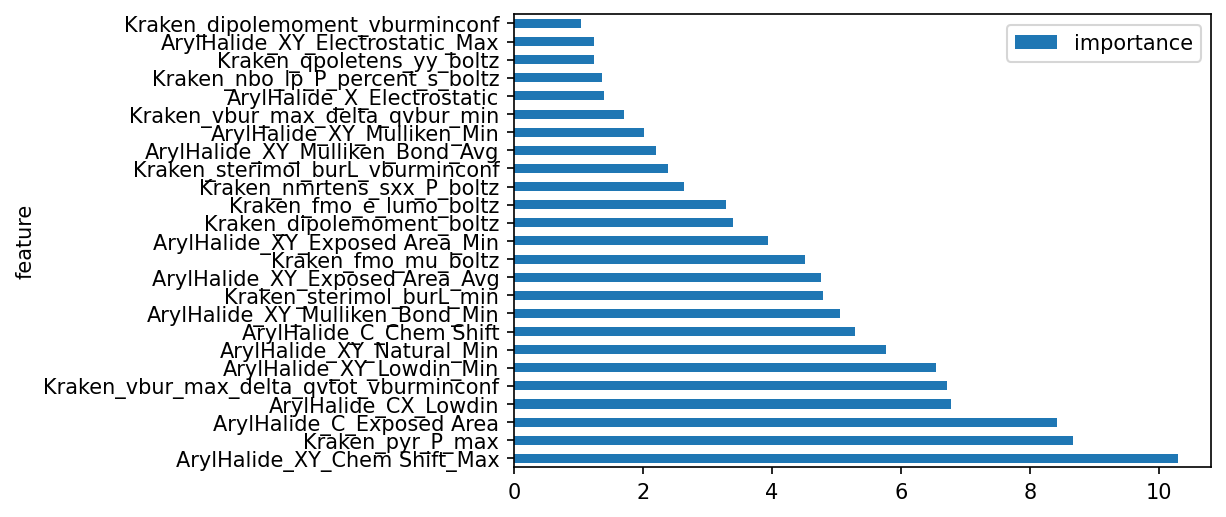

In [13]:
#Top features from Lasso regression, pls note they are quite different from other tree-based ensemble models
coefs=lasso_search.best_estimator_.named_steps['model'].coef_
importance=np.abs(coefs)
features=X_train.columns

df=pd.DataFrame(zip(features,importance))
df2 = df.sort_values(by=[1], ascending=False).head(25)
df2.columns = ['feature', 'importance']
df2.set_index('feature',inplace=True)
df2.plot(kind='barh')

In [14]:
%load_ext watermark

In [15]:
%watermark --iversions

matplotlib: 3.3.3
sklearn   : 0.0
numpy     : 1.19.2
pandas    : 1.2.0

